##### Copyright 2018 The TensorFlow Authors.

Random agent reward: 42.0
Random agent reward: 6.5
Reflex agent reward: 183.0
Improved agent reward: 175.0
Running vacuum cleaner experiments...
RandomAgent - Dirt Prob: 0.05, Mean Reward: 10.93
RandomAgent - Dirt Prob: 0.10, Mean Reward: 20.18
RandomAgent - Dirt Prob: 0.15, Mean Reward: 41.02
RandomAgent - Dirt Prob: 0.20, Mean Reward: 32.88
RandomAgent - Dirt Prob: 0.25, Mean Reward: 52.23
RandomAgent - Dirt Prob: 0.30, Mean Reward: 49.00
ReflexAgent - Dirt Prob: 0.05, Mean Reward: 207.70
ReflexAgent - Dirt Prob: 0.10, Mean Reward: 298.82
ReflexAgent - Dirt Prob: 0.15, Mean Reward: 342.23
ReflexAgent - Dirt Prob: 0.20, Mean Reward: 374.98
ReflexAgent - Dirt Prob: 0.25, Mean Reward: 419.23
ReflexAgent - Dirt Prob: 0.30, Mean Reward: 459.27
ImprovedAgent - Dirt Prob: 0.05, Mean Reward: 158.30
ImprovedAgent - Dirt Prob: 0.10, Mean Reward: 235.35
ImprovedAgent - Dirt Prob: 0.15, Mean Reward: 258.98
ImprovedAgent - Dirt Prob: 0.20, Mean Reward: 318.57
ImprovedAgent - Dirt Prob: 0.25, Mean

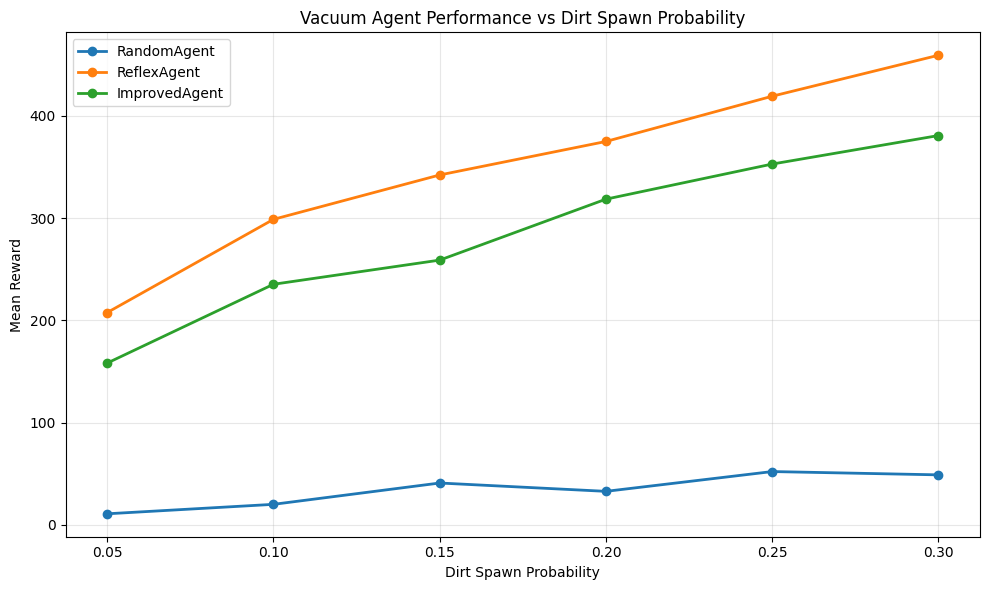


Summary Statistics:
RandomAgent: Mean = 34.37, Std = 14.89
ReflexAgent: Mean = 350.37, Std = 81.94
ImprovedAgent: Mean = 284.15, Std = 75.39
{'flu': 0.8205128205128205, 'cold': 0.17094017094017097, 'allergy': 0.008547008547008546}
Experiments complete!


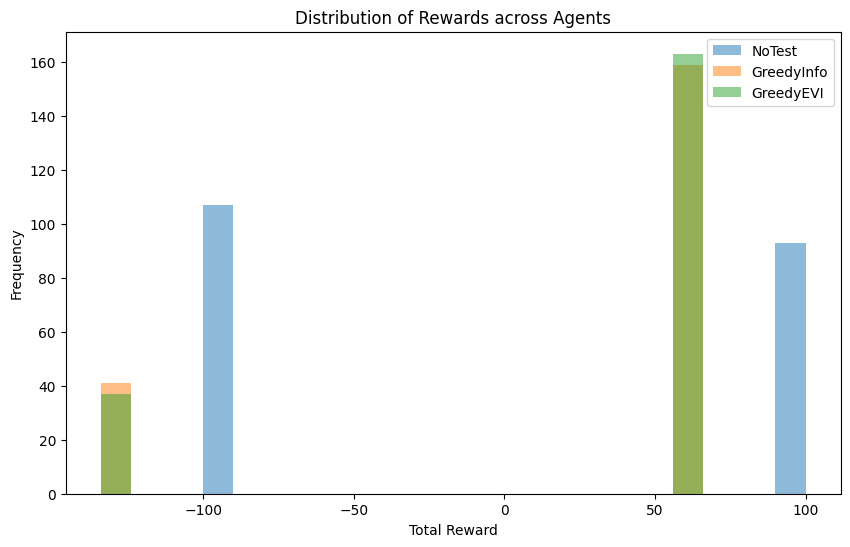


Summary Statistics:
NoTest: Mean = -7.00, Std = 99.75
GreedyInfo: Mean = 25.00, Std = 80.74
GreedyEVI: Mean = 29.00, Std = 77.66


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import defaultdict
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import copy

np.random.seed(42)
random.seed(42)

#--------------------
class VacuumEnvironment:
    """2D Grid environment for vacuum cleaner agent"""

    def __init__(self, width=5, height=5, dirt_spawn_prob=0.1):
        self.width = width
        self.height = height
        self.dirt_spawn_prob = dirt_spawn_prob
        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.grid = np.random.choice([0, 1], size=(self.height, self.width), p=[0.7, 0.3])
        self.agent_pos = [0, 0]  # [row, col]
        self.total_reward = 0
        self.steps = 0
        return self.get_state()

    def get_state(self, full_observability=False):
        """Get current state - local or full observation"""
        if full_observability:
            return {
                'position': tuple(self.agent_pos),
                'grid': self.grid.copy(),
                'dirty_here': bool(self.grid[self.agent_pos[0], self.agent_pos[1]])
            }
        else:
            return {
                'position': tuple(self.agent_pos),
                'dirty_here': bool(self.grid[self.agent_pos[0], self.agent_pos[1]])
            }

    def step(self, action, full_observability=False):
        """Execute action and return (next_state, reward, done)"""
        reward = -0.25  # Step penalty
        self.steps += 1

        if action == 'SUCK':
            if self.grid[self.agent_pos[0], self.agent_pos[1]] == 1:
                self.grid[self.agent_pos[0], self.agent_pos[1]] = 0
                reward += 10  # Cleaning reward

        elif action == 'LEFT':
            if self.agent_pos[1] > 0:
                self.agent_pos[1] -= 1
                reward -= 1  # Move penalty
            else:
                reward -= 0.5  # Bump penalty

        elif action == 'RIGHT':
            if self.agent_pos[1] < self.width - 1:
                self.agent_pos[1] += 1
                reward -= 1  # Move penalty
            else:
                reward -= 0.5  # Bump penalty

        elif action == 'UP':
            if self.agent_pos[0] > 0:
                self.agent_pos[0] -= 1
                reward -= 1  # Move penalty
            else:
                reward -= 0.5  # Bump penalty

        elif action == 'DOWN':
            if self.agent_pos[0] < self.height - 1:
                self.agent_pos[0] += 1
                reward -= 1  # Move penalty
            else:
                reward -= 0.5  # Bump penalty

        # NOP does nothing, just step penalty

        # Stochastic dirt respawn
        for i in range(self.height):
            for j in range(self.width):
                if self.grid[i, j] == 0 and np.random.random() < self.dirt_spawn_prob:
                    self.grid[i, j] = 1

        self.total_reward += reward
        done = self.steps >= 100  # Episode length limit

        return self.get_state(full_observability), reward, done

    def render(self):
        """Visualize current state"""
        display_grid = self.grid.copy().astype(str)
        display_grid[self.agent_pos[0], self.agent_pos[1]] = 'A'
        print(f"Step {self.steps}, Total Reward: {self.total_reward:.2f}")
        for row in display_grid:
            print(' '.join(row))
        print()

#---------------------------------------------
def random_agent(state):
    """Chooses a random action regardless of environment."""
    actions = ['SUCK', 'LEFT', 'RIGHT', 'UP', 'DOWN', 'NOP']
    return random.choice(actions)


def reflex_agent(state):
    """If current cell is dirty, suck. Otherwise move randomly."""
    if state['dirty_here']:
        return 'SUCK'
    return random.choice(['LEFT', 'RIGHT', 'UP', 'DOWN'])


def improved_agent(state, memory):
    """
    Improved agent: avoids revisiting recent positions, explores with bias.
    memory is a dict with keys:
      - 'last_positions': list of last visited positions
      - 'exploration_bias': float [0,1], probability to explore randomly
    """
    if state['dirty_here']:
        return 'SUCK'

    current_pos = state['position']
    memory['last_positions'].append(current_pos)
    if len(memory['last_positions']) > 5:
        memory['last_positions'].pop(0)

    if random.random() < memory['exploration_bias']:
        return random.choice(['LEFT', 'RIGHT', 'UP', 'DOWN'])

    possible_moves = ['LEFT', 'RIGHT', 'UP', 'DOWN']
    move_scores = []

    for move in possible_moves:
        next_pos = list(current_pos)
        if move == 'LEFT': next_pos[1] -= 1
        elif move == 'RIGHT': next_pos[1] += 1
        elif move == 'UP': next_pos[0] -= 1
        elif move == 'DOWN': next_pos[0] += 1

        score = 1.0
        for i, old_pos in enumerate(memory['last_positions']):
            if tuple(next_pos) == old_pos:
                score -= 0.2 * (len(memory['last_positions']) - i)
        move_scores.append(score)

    best_move_idx = np.argmax(move_scores)
    return possible_moves[best_move_idx]
#---------------------------------------
def run_episode(env, agent_fn, steps=100, full_observability=False):
    """
    Runs one episode of the environment using the given agent function.
    - env: environment object (with reset(), step())
    - agent_fn: function(state) -> action
    - steps: max number of steps to simulate
    - full_observability: bool, whether to expose full grid to agent
    Returns: cumulative reward
    """
    state = env.reset()
    total_reward = 0

    for _ in range(steps):
        action = agent_fn(state)
        next_state, reward, done = env.step(action, full_observability=full_observability)
        total_reward += reward
        state = next_state
        if done:
            break

    return total_reward
def run_episode_with_memory(env, agent_fn, steps=100, memory=None, full_observability=False):
    state = env.reset()
    total_reward = 0

    for _ in range(steps):
        action = agent_fn(state, memory)
        next_state, reward, done = env.step(action, full_observability=full_observability)
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

#--------------------------------
# Quick Test (fixed)
# Quick Test (fixed)
env = VacuumEnvironment(width=5, height=5, dirt_spawn_prob=0.2)
reward = run_episode(env, random_agent, steps=50)
print("Random agent reward:", reward)

#----------------------------
# Quick Test for all agents
env = VacuumEnvironment(width=5, height=5, dirt_spawn_prob=0.2)

# Random Agent
reward_random = run_episode(env, random_agent, steps=50)
print("Random agent reward:", reward_random)

# Reflex Agent
reward_reflex = run_episode(env, reflex_agent, steps=50)
print("Reflex agent reward:", reward_reflex)

# Improved Agent (needs memory)
def run_episode_with_memory(env, agent_fn, steps=100, memory=None):
    state = env.reset()
    total_reward = 0

    for _ in range(steps):
        action = agent_fn(state, memory)
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

memory = {"last_positions": [], "exploration_bias": 0.3}
reward_improved = run_episode_with_memory(env, improved_agent, steps=50, memory=memory)
print("Improved agent reward:", reward_improved)

#------------------------------
# --- Agent Wrappers ---
class RandomAgent:
    def __init__(self):
        self.name = "RandomAgent"
    def __call__(self, state):
        return random_agent(state)

class ReflexAgent:
    def __init__(self):
        self.name = "ReflexAgent"
    def __call__(self, state):
        return reflex_agent(state)

class ImprovedAgent:
    def __init__(self, exploration_bias=0.3):
        self.name = "ImprovedAgent"
        self.memory = {"last_positions": [], "exploration_bias": exploration_bias}
    def __call__(self, state):
        return improved_agent(state, self.memory)
# --- Cell 6: Experiments ---

def run_experiments(agents, dirt_probs, num_episodes=20, full_observability=False):
    """Run experiments across different dirt spawn probabilities"""
    results = {}

    for agent in agents:
        results[agent.name] = []

        for dirt_prob in dirt_probs:
            episode_rewards = []

            for episode in range(num_episodes):
                env = VacuumEnvironment(width=5, height=5, dirt_spawn_prob=dirt_prob)
                reward = run_episode(env, agent, full_observability=full_observability)
                episode_rewards.append(reward)

            mean_reward = np.mean(episode_rewards)
            results[agent.name].append(mean_reward)
            print(f"{agent.name} - Dirt Prob: {dirt_prob:.2f}, Mean Reward: {mean_reward:.2f}")

    return results
#---------------------------



# Run experiments
print("Running vacuum cleaner experiments...")
agents = [RandomAgent(), ReflexAgent(), ImprovedAgent()]
dirt_probabilities = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

results = run_experiments(agents, dirt_probabilities, num_episodes=20)
print("\nExperiments complete!")

# Plot results
plt.figure(figsize=(10, 6))

for agent_name, rewards in results.items():
    plt.plot(dirt_probabilities, rewards, marker='o', linewidth=2, label=agent_name)

plt.xlabel('Dirt Spawn Probability')
plt.ylabel('Mean Reward')
plt.title('Vacuum Agent Performance vs Dirt Spawn Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for agent_name, rewards in results.items():
    print(f"{agent_name}: Mean = {np.mean(rewards):.2f}, Std = {np.std(rewards):.2f}")
#------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------


class MedicalEnvironment:
    """Medical diagnosis environment with Bayesian reasoning"""

    def __init__(self):
        # Disease probabilities (priors)
        self.diseases = ['flu', 'cold', 'allergy']
        self.disease_priors = {'flu': 0.3, 'cold': 0.5, 'allergy': 0.2}

        # Available tests and their costs
        self.tests = ['fever_test', 'cough_test', 'runny_nose_test', 'fatigue_test', 'sneezing_test']
        self.test_costs = {
            'fever_test': 10,
            'cough_test': 5,
            'runny_nose_test': 5,
            'fatigue_test': 8,
            'sneezing_test': 6
        }

        # Test likelihoods P(test_result=True | disease)
        self.test_likelihoods = {
            'flu': {
                'fever_test': 0.8,
                'cough_test': 0.7,
                'runny_nose_test': 0.3,
                'fatigue_test': 0.9,
                'sneezing_test': 0.2
            },
            'cold': {
                'fever_test': 0.2,
                'cough_test': 0.8,
                'runny_nose_test': 0.9,
                'fatigue_test': 0.4,
                'sneezing_test': 0.6
            },
            'allergy': {
                'fever_test': 0.1,
                'cough_test': 0.3,
                'runny_nose_test': 0.8,
                'fatigue_test': 0.2,
                'sneezing_test': 0.9
            }
        }

        self.reset()

    def reset(self):
        """Reset environment for new episode"""
        # Randomly select true disease based on priors
        self.true_disease = np.random.choice(
            self.diseases,
            p=[self.disease_priors[d] for d in self.diseases]
        )

        self.observed_tests = {}  # Test results observed so far
        self.total_cost = 0
        self.done = False

        return self.get_state()

    def get_state(self):
        """Get current state (observed test results)"""
        return {
            'observed_tests': self.observed_tests.copy(),
            'available_tests': [t for t in self.tests if t not in self.observed_tests],
            'total_cost': self.total_cost
        }

    def step(self, action):
        """Execute action and return (next_state, reward, done)"""
        action_type, action_value = action
        reward = 0

        if action_type == 'order_test':
            test_name = action_value
            if test_name in self.observed_tests:
                # Already performed this test
                reward = -5  # Small penalty for redundant test
            elif test_name not in self.tests:
                # Invalid test
                reward = -10
            else:
                # Perform test
                cost = self.test_costs[test_name]
                self.total_cost += cost
                reward = -cost

                # Generate test result based on true disease
                likelihood = self.test_likelihoods[self.true_disease][test_name]
                test_result = np.random.random() < likelihood
                self.observed_tests[test_name] = test_result

        elif action_type == 'diagnose':
            diagnosis = action_value
            if diagnosis == self.true_disease:
                reward = 100  # Correct diagnosis
            else:
                reward = -100  # Wrong diagnosis
            self.done = True

        return self.get_state(), reward, self.done
#----------------------------------------------------------
# Cell 8 → Bayes Posterior
def posterior(prior, likelihoods, observations):
    """
    Compute Bayesian posterior distribution.

    prior: dict {hypothesis: prior probability}
    likelihoods: dict of dicts {hypothesis: {obs: P(obs|hyp)}}
    observations: dict {obs: value (True/False)}

    Returns:
        dict {hypothesis: posterior probability}
    """
    unnormalized = {}

    for h in prior:
        prob = prior[h]
        for obs, val in observations.items():
            if obs in likelihoods[h]:
                if val:  # P(obs|h)
                    prob *= likelihoods[h][obs]
                else:    # P(~obs|h) = 1 - P(obs|h)
                    prob *= (1 - likelihoods[h][obs])
        unnormalized[h] = prob

    # Normalize
    total = sum(unnormalized.values())
    if total == 0:
        return {h: 0 for h in prior}
    return {h: unnormalized[h] / total for h in prior}
#--------------------------------------------------
# Cell 9 - Sanity Test Posterior
prior = {"flu": 0.3, "cold": 0.5, "allergy": 0.2}

likelihoods = {
    "flu": {"fever": 0.8, "sneezing": 0.2},
    "cold": {"fever": 0.2, "sneezing": 0.6},
    "allergy": {"fever": 0.1, "sneezing": 0.9},
}

observations = {"fever": True, "sneezing": False}

print(posterior(prior, likelihoods, observations))
#---------------------------------------------
# Cell 10 – Define Medical Agents (NoTest, GreedyInfo, GreedyEVI)

class MedicalAgent:
    """Base class for medical diagnosis agents"""
    def __init__(self, name="BaseMedicalAgent"):
        self.name = name

    def act(self, state, env: MedicalEnvironment):
        raise NotImplementedError


class NoTestAgent(MedicalAgent):
    """
    Strategy: Skip all tests and diagnose immediately
    Chooses the most likely disease based on priors
    """
    def __init__(self):
        super().__init__("NoTest")

    def act(self, state, env: MedicalEnvironment):
        # Pick the disease with the highest prior probability
        best_disease = max(env.disease_priors, key=env.disease_priors.get)
        return ('diagnose', best_disease)


class GreedyInfoAgent(MedicalAgent):
    """
    Strategy: Pick the test that maximizes information gain (entropy reduction)
    """
    def __init__(self):
        super().__init__("GreedyInfo")

    def act(self, state, env: MedicalEnvironment):
        # If no tests left → diagnose using posterior
        if not state['available_tests']:
            posteriors = self.compute_posteriors(state, env)
            best_disease = max(posteriors, key=posteriors.get)
            return ('diagnose', best_disease)

        # Otherwise, pick the test with max expected info gain
        best_test, best_gain = None, -1
        for test in state['available_tests']:
            gain = self.expected_information_gain(test, state, env)
            if gain > best_gain:
                best_test, best_gain = test, gain

        return ('order_test', best_test)

    def compute_posteriors(self, state, env):
        """Bayesian update given observed test results"""
        probs = {}
        for d in env.diseases:
            prob_d = env.disease_priors[d]
            for test, result in state['observed_tests'].items():
                likelihood = env.test_likelihoods[d][test]
                prob_d *= likelihood if result else (1 - likelihood)
            probs[d] = prob_d
        total = sum(probs.values())
        return {d: p/total for d, p in probs.items()}

    def expected_information_gain(self, test, state, env):
        """Compute expected entropy reduction if we perform a test"""
        posteriors_before = self.compute_posteriors(state, env)

        def entropy(probs):
            return -sum(p*np.log2(p) for p in probs.values() if p > 0)

        H_before = entropy(posteriors_before)

        # For each possible result (True/False)
        exp_H_after = 0
        for result in [True, False]:
            # Simulate new state
            new_state = {
                'observed_tests': {**state['observed_tests'], test: result},
                'available_tests': [t for t in state['available_tests'] if t != test],
                'total_cost': state['total_cost']
            }
            posteriors_after = self.compute_posteriors(new_state, env)
            prob_result = sum(
                posteriors_before[d] * (env.test_likelihoods[d][test] if result else 1 - env.test_likelihoods[d][test])
                for d in env.diseases
            )
            exp_H_after += prob_result * entropy(posteriors_after)

        return H_before - exp_H_after


class GreedyEVI(MedicalAgent):
    """
    Strategy: Greedy Expected Value of Information (EVI)
    Chooses the test that maximizes expected reward considering cost
    """
    def __init__(self):
        super().__init__("GreedyEVI")

    def act(self, state, env: MedicalEnvironment):
        if not state['available_tests']:
            # Diagnose using max posterior
            posteriors = self.compute_posteriors(state, env)
            best_disease = max(posteriors, key=posteriors.get)
            return ('diagnose', best_disease)

        # Otherwise, evaluate expected utility of each test
        best_test, best_value = None, -1e9
        for test in state['available_tests']:
            value = self.expected_value_of_test(test, state, env)
            if value > best_value:
                best_test, best_value = test, value

        # If all tests are worse than immediate diagnosis → diagnose now
        diagnose_value = self.expected_diagnosis_value(state, env)
        if diagnose_value >= best_value:
            return ('diagnose', max(self.compute_posteriors(state, env), key=self.compute_posteriors(state, env).get))

        return ('order_test', best_test)

    def compute_posteriors(self, state, env):
        """Same as in GreedyInfoAgent"""
        probs = {}
        for d in env.diseases:
            prob_d = env.disease_priors[d]
            for test, result in state['observed_tests'].items():
                likelihood = env.test_likelihoods[d][test]
                prob_d *= likelihood if result else (1 - likelihood)
            probs[d] = prob_d
        total = sum(probs.values())
        return {d: p/total for d, p in probs.items()}

    def expected_diagnosis_value(self, state, env):
        """Expected value if we diagnose immediately"""
        posteriors = self.compute_posteriors(state, env)
        best_prob = max(posteriors.values())
        return best_prob * 100 + sum(-env.test_costs[t] for t in state['observed_tests'])

    def expected_value_of_test(self, test, state, env):
        """Expected value of performing a test before diagnosing"""
        posteriors_before = self.compute_posteriors(state, env)
        test_cost = env.test_costs[test]

        exp_value = -test_cost
        for result in [True, False]:
            new_state = {
                'observed_tests': {**state['observed_tests'], test: result},
                'available_tests': [t for t in state['available_tests'] if t != test],
                'total_cost': state['total_cost'] + test_cost
            }
            posteriors_after = self.compute_posteriors(new_state, env)
            best_prob = max(posteriors_after.values())
            prob_result = sum(
                posteriors_before[d] * (env.test_likelihoods[d][test] if result else 1 - env.test_likelihoods[d][test])
                for d in env.diseases
            )
            exp_value += prob_result * (best_prob * 100)
        return exp_value
#------------------------------------------------------------------
# Cell 11 – Run Experiments
# Cell 11 – Run Experiments
rewards = {"NoTest": [], "GreedyInfo": [], "GreedyEVI": []}

num_runs = 200
for run in range(num_runs):
    env = MedicalEnvironment()

    # NoTest baseline: directly diagnose using priors
    agent_notest = NoTestAgent()
    _, r_notest, _ = env.step(agent_notest.act(env.get_state(), env))
    rewards["NoTest"].append(r_notest)

    # GreedyInfo: chooses most informative test
    env.reset()
    agent_info = GreedyInfoAgent()
    done = False
    total_reward_info = 0
    while not done:
        action = agent_info.act(env.get_state(), env)
        _, r, done = env.step(action)
        total_reward_info += r
    rewards["GreedyInfo"].append(total_reward_info)

    # GreedyEVI: chooses test with max expected value of information
    env.reset()
    agent_evi = GreedyEVI()
    done = False
    total_reward_evi = 0
    while not done:
        action = agent_evi.act(env.get_state(), env)
        _, r, done = env.step(action)
        total_reward_evi += r
    rewards["GreedyEVI"].append(total_reward_evi)

print("Experiments complete!")

# Plot histograms
plt.figure(figsize=(10, 6))
for name, vals in rewards.items():
    plt.hist(vals, bins=20, alpha=0.5, label=name)
plt.xlabel("Total Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Rewards across Agents")
plt.legend()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
for name, vals in rewards.items():
    print(f"{name}: Mean = {np.mean(vals):.2f}, Std = {np.std(vals):.2f}")







## **Introduction to Colab and Python**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome to this Colab where you will get a quick introduction to the Python programming language and the environment used for the course's exercises: Colab.

Colab is a Python development environment that runs in the browser using Google Cloud.

For example, to print "Hello World", just hover the mouse over [ ] and press the play button to the upper left. Or press shift-enter to execute.

In [ ]:
print("Hello World")

## Functions, Conditionals, and Iteration
Let's create a Python function, and call it from a loop.

In [ ]:
def HelloWorldXY(x, y):
  if (x < 10):
    print("Hello World, x was < 10")
  elif (x < 20):
    print("Hello World, x was >= 10 but < 20")
  else:
    print("Hello World, x was >= 20")
  return x + y

for i in range(8, 25, 5):  # i=8, 13, 18, 23 (start, stop, step)
  print("--- Now running with i: {}".format(i))
  r = HelloWorldXY(i,i)
  print("Result from HelloWorld: {}".format(r))

In [ ]:
print(HelloWorldXY(1,2))

Easy, right?

If you want a loop starting at 0 to 2 (exclusive) you could do any of the following

In [ ]:
print("Iterate over the items. `range(2)` is like a list [0,1].")
for i in range(2):
  print(i)

print("Iterate over an actual list.")
for i in [0,1]:
  print(i)

print("While works")
i = 0
while i < 2:
  print(i)
  i += 1

In [ ]:
print("Python supports standard key words like continue and break")
while True:
  print("Entered while")
  break

## Numpy and lists
Python has lists built into the language.
However, we will use a library called numpy for this.
Numpy gives you lots of support functions that are useful when doing Machine Learning.

Here, you will also see an import statement. This statement makes the entire numpy package available and we can access those symbols using the abbreviated 'np' syntax.

In [ ]:
import numpy as np  # Make numpy available using np.

# Create a numpy array, and append an element
a = np.array(["Hello", "World"])
a = np.append(a, "!")
print("Current array: {}".format(a))
print("Printing each element")
for i in a:
  print(i)

print("\nPrinting each element and their index")
for i,e in enumerate(a):
  print("Index: {}, was: {}".format(i, e))

In [ ]:
print("\nShowing some basic math on arrays")
b = np.array([0,1,4,3,2])
print("Max: {}".format(np.max(b)))
print("Average: {}".format(np.average(b)))
print("Max index: {}".format(np.argmax(b)))

In [ ]:
print("\nYou can print the type of anything")
print("Type of b: {}, type of b[0]: {}".format(type(b), type(b[0])))

In [ ]:
print("\nUse numpy to create a [3,3] dimension array with random number")
c = np.random.rand(3, 3)
print(c)

In [ ]:
print("\nYou can print the dimensions of arrays")
print("Shape of a: {}".format(a.shape))
print("Shape of b: {}".format(b.shape))
print("Shape of c: {}".format(c.shape))
print("...Observe, Python uses both [0,1,2] and (0,1,2) to specify lists")

## Colab Specifics

Colab is a virtual machine you can access directly. To run commands at the VM's terminal, prefix the line with an exclamation point (!).


In [ ]:
print("\nDoing $ls on filesystem")
!ls -l
!pwd

In [ ]:
print("Install numpy")  # Just for test, numpy is actually preinstalled in all Colab instances
!pip install numpy

**Exercise**

Create a code cell underneath this text cell and add code to:


*   List the path of the current directory (pwd)
* Go to / (cd) and list the content (ls -l)

In [ ]:
!pwd
!cd /
!ls -l
print("Hello")

All usage of Colab in this course is completely free or charge. Even GPU usage is provided free of charge for some hours of usage every day.

**Using GPUs**
* Many of the exercises in the course executes more quickly by using GPU runtime: Runtime | Change runtime type | Hardware accelerator | GPU

**Some final words on Colab**
*   You execute each cell in order, you can edit & re-execute cells if you want
*   Sometimes, this could have unintended consequences. For example, if you add a dimension to an array and execute the cell multiple times, then the cells after may not work. If you encounter problem reset your environment:
  *   Runtime -> Restart runtime... Resets your Python shell
  *   Runtime -> Restart all runtimes... Will reset the Colab image, and get you back to a 100% clean environment
* You can also clear the output in the Colab by doing: Edit -> Clear all outputs
* Colabs in this course are loaded from GitHub. Save to your Google Drive if you want a copy with your code/output: File -> Save a copy in Drive...

**Learn More**
*   Check out [this](https://www.youtube.com/watch?v=inN8seMm7UI&list=PLQY2H8rRoyvwLbzbnKJ59NkZvQAW9wLbx&index=3) episode of #CodingTensorFlow, and don't forget to subscribe to the YouTube channel ;)
